In [1]:
# input: iturbide_gaia-data
# output: manual-periodogram

import phoebe
from phoebe import u, c

import numpy as np

import scienceplots
import matplotlib.pyplot as plt
plt.style.use('science')

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
importlib.reload(gen_utils)

logger = phoebe.logger(clevel='WARNING')

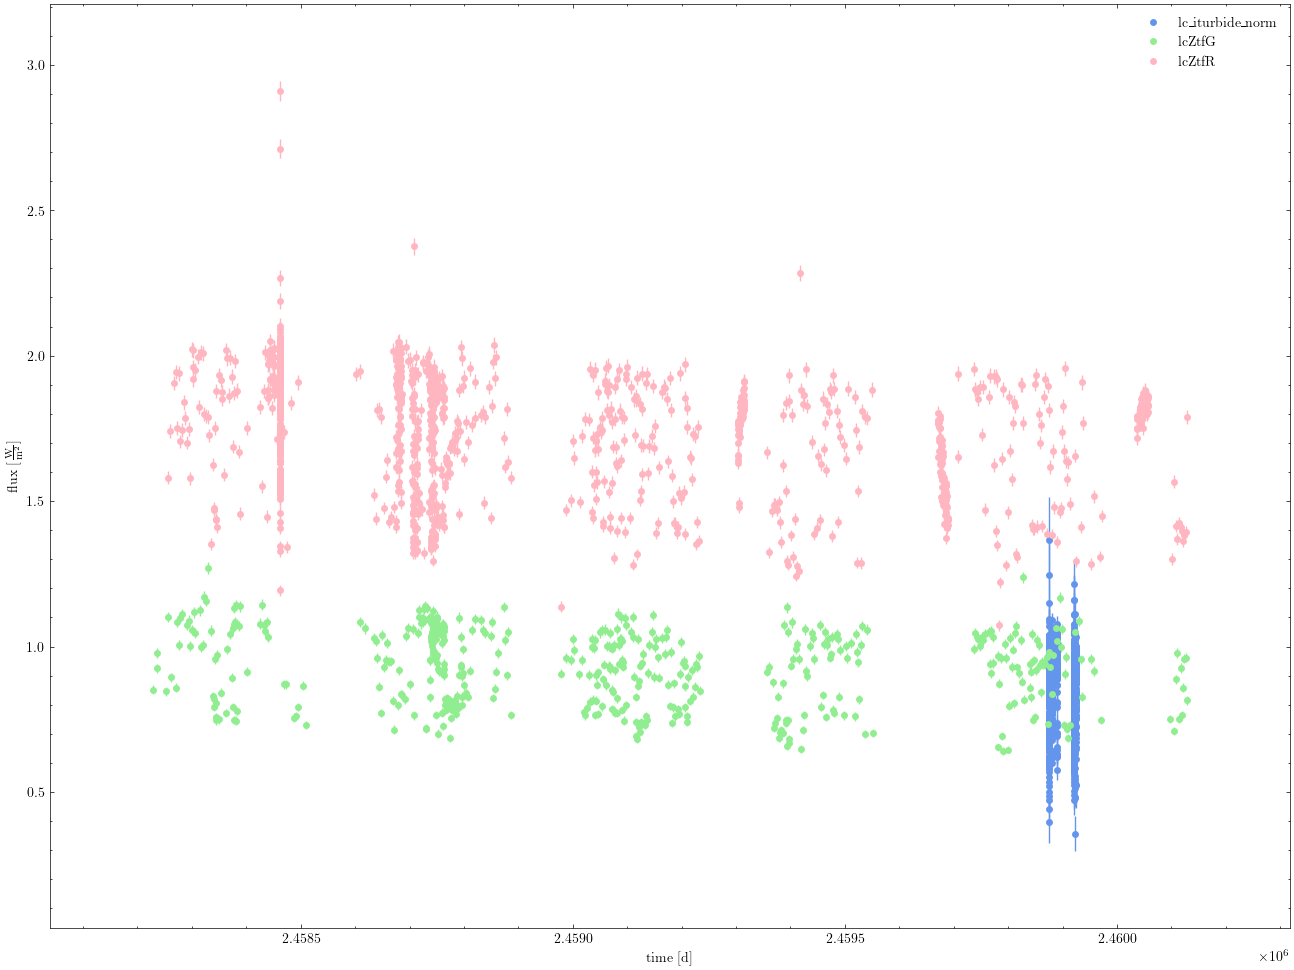

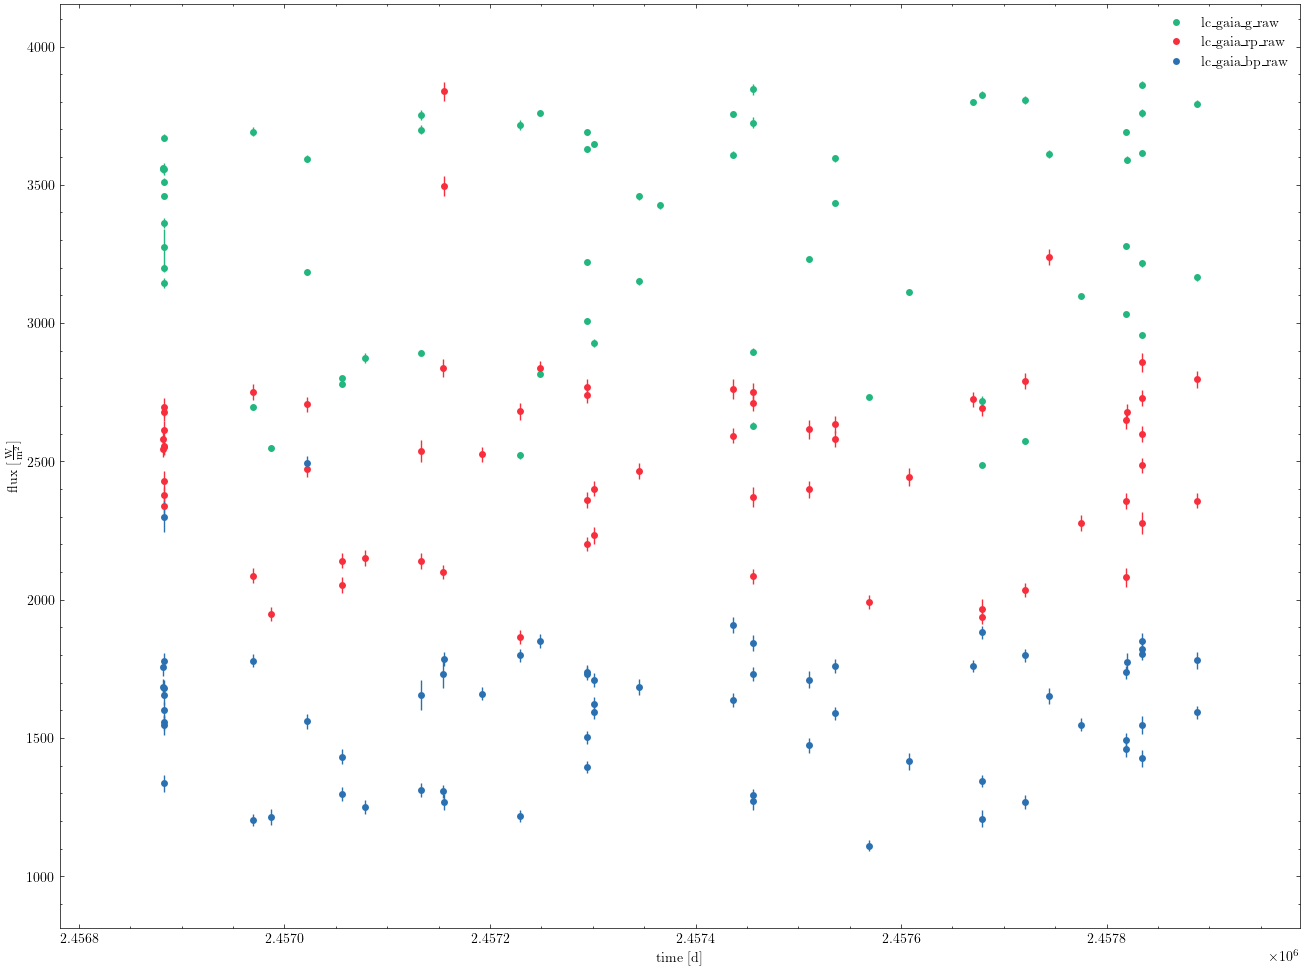

(<autofig.figure.Figure | 1 axes | 3 call(s)>,
 <Figure size 1600x1200 with 1 Axes>)

In [2]:
# b = phoebe.load("../bundle-saves/iturbide_gaia-data")
# b = phoebe.load("../bundle-saves/aviles-data/iturbide_gaia-data")
# b = phoebe.load("../bundle-saves/comp-LID-3/iturbide_gaia-data")
# b = phoebe.load("../bundle-saves/iturbide-gaia-ztf")
b = gen_utils.loadBundle(bundleName="semidetached-model", parentFolder="..")
b.plot(kind='lc', dataset=[d for d in b.datasets if 'raw' not in d], show=True, legend=True, marker='.', s=0.008, color=gen_utils.ITURBIDE_PLOT_COLORS | gen_utils.ZTF_PLOT_COLORS, fig=plt.figure(figsize=(16, 12)))
b.plot(dataset=[d for d in b.datasets if 'gaia' in d and 'raw' in d], show=True, legend=True, marker='.', s=0.008, fig=plt.figure(figsize=(16,12)), color=gen_utils.GAIA_PLOT_COLORS)

In [3]:
iturbideTimes = b.get_value(qualifier='times', dataset='lcZtfG')

MIN_FREQ = 0.001 # avoiding zero
# MAX_FREQ = (1 / (2*(60*u.second).to(u.day))).value # windowing limit windowed observations, taking delta-t = 60sec
MAX_FREQ = 1 # 1 hour period

N_0 = 40
GRID_SIZE = N_0 * (iturbideTimes[-1] - iturbideTimes[0]) * float(MAX_FREQ)
print(GRID_SIZE)

# setting a much finer grid for lower frequencies, since this is where we expect the orbital period to be
sub1 = phoebe.linspace(MIN_FREQ, MAX_FREQ, int(GRID_SIZE), endpoint=False)
# sub2 = phoebe.linspace(2, float(MAX_FREQ), int(GRID_SIZE) // 100)
# manualPeriodSample = np.concatenate([sub1, sub2])
manualPeriodSample = sub1

len(manualPeriodSample), manualPeriodSample[0], manualPeriodSample[-1]

75957.93537184596


(75957, 0.001, 0.9999868478217939)

### Auto periodogram

ParameterSet: 10 parameters
R  period@lcperiod_iturbide_au...: [0.00123237 0.00126318
 0.00129398 ...
 0.97905312 0.97908393
 0.97911474] d
R  power@lcperiod_iturbide_aut...: [0.00723796 0.00558495
 0.00383535 ... 0.00786706
 0.00420818 0.00216324]
   period_factor@lcperiod_itur...: 1.0
R  fitted_twigs@lcperiod_iturb...: ['period@binary@orbit@component']
R  fitted_values@lcperiod_itur...: [0.001910167204988769]
R  fitted_units@lcperiod_iturb...: ['d']
   adopt_parameters@lcperiod_i...: ['period@binary@orbit@component']
   adopt_distributions@lcperio...: False
   adopt_values@lcperiod_iturb...: True
   comments@lcperiod_iturbide_...: 


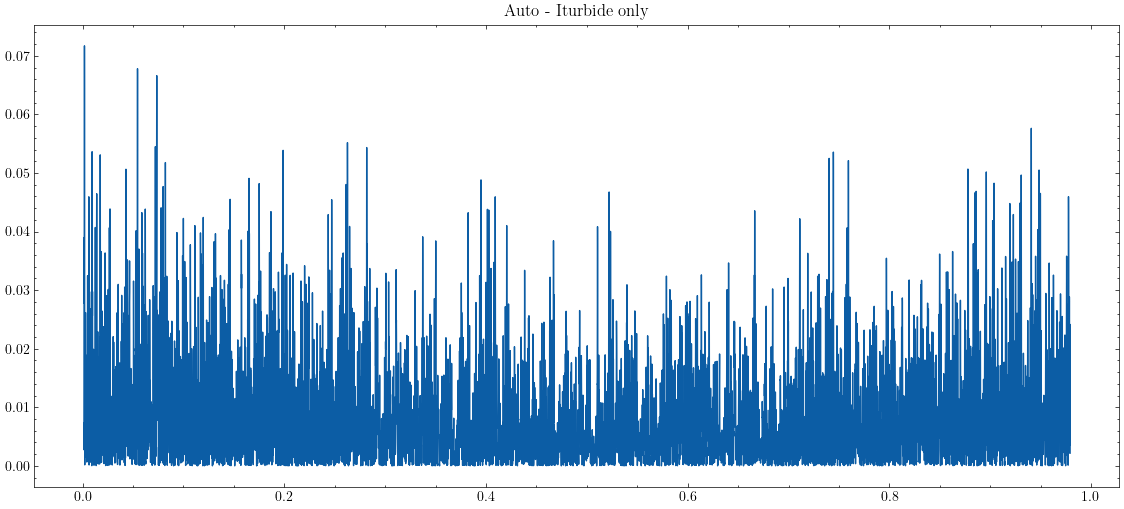

In [4]:
b.add_solver('estimator.lc_periodogram', solver='lcperiod_iturbide_auto', overwrite=True, algorithm='ls')
b.run_solver('lcperiod_iturbide_auto', solution='lcperiod_iturbide_auto_solution', overwrite=True)
print(b['lcperiod_iturbide_auto_solution'])

plt.figure(figsize=(14,6))
plt.plot(b.get_value('period@lcperiod_iturbide_auto_solution'), b.get_value('power@lcperiod_iturbide_auto_solution'))
plt.title("Auto - Iturbide only")
plt.show()

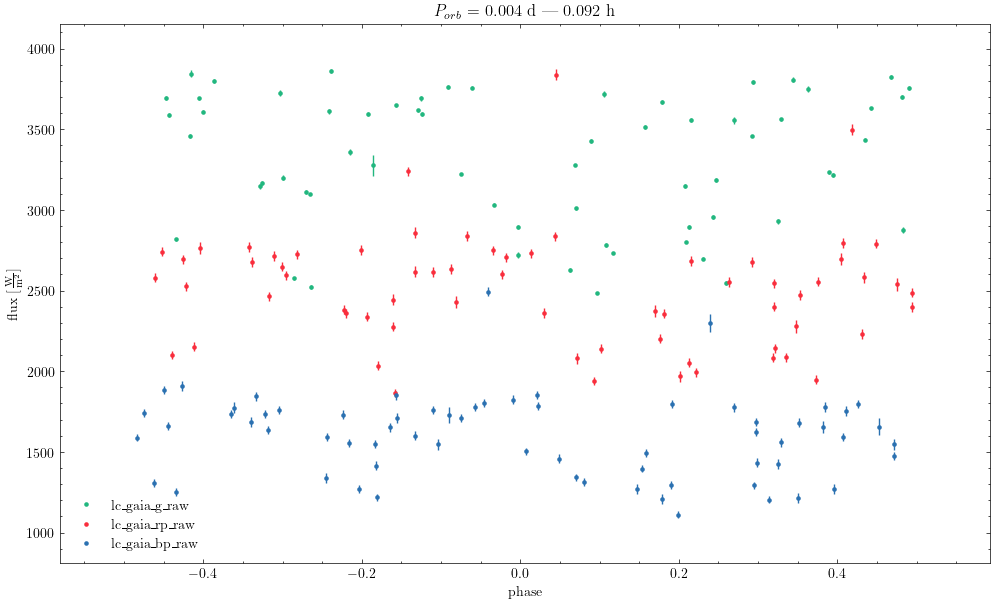

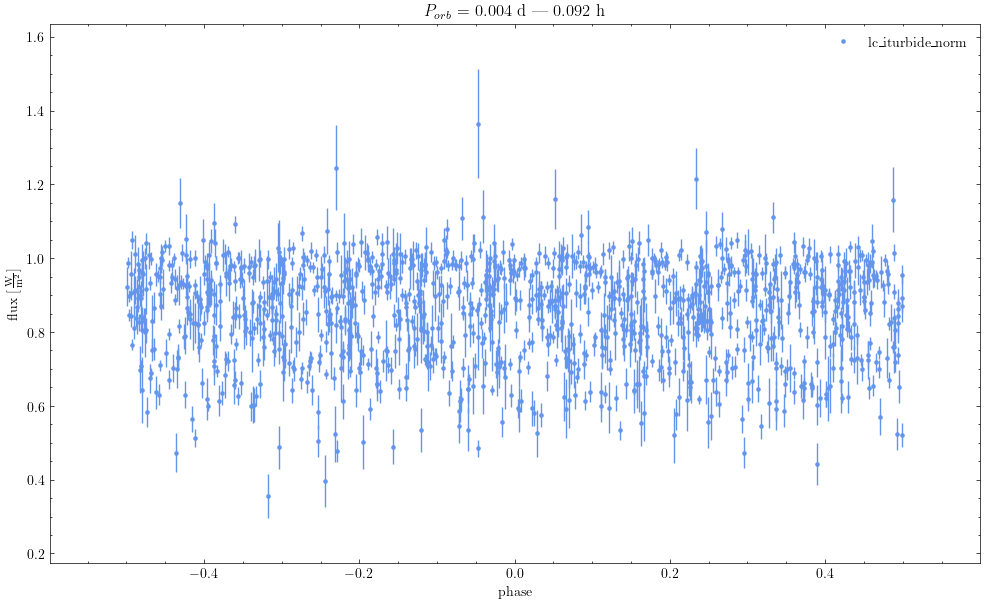

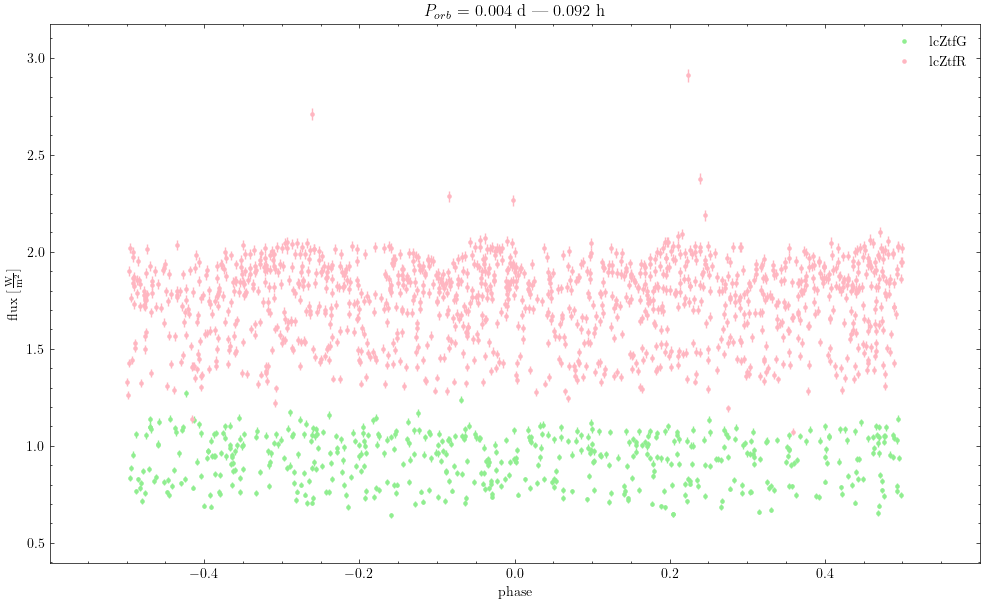

In [5]:
importlib.reload(gen_utils)
b.adopt_solution('lcperiod_iturbide_auto_solution', period_factor=2)
period = b.get_quantity(qualifier='period', component='binary')

gen_utils.abilitateDatasets(b, ['lc_gaia_g_raw', 'lc_gaia_rp_raw', 'lc_gaia_bp_raw'])
gen_utils.phasePlotEnabledData(b, fig=plt.figure(figsize=(12, 7)))

gen_utils.abilitateDatasets(b, ['lc_iturbide_norm'])
gen_utils.phasePlotEnabledData(b, fig=plt.figure(figsize=(12, 7)))

gen_utils.abilitateDatasets(b, ['lcZtfG', 'lcZtfR'])
gen_utils.phasePlotEnabledData(b, fig=plt.figure(figsize=(12, 7)))
# b.plot(x='phase', dataset=[d for d in b.datasets if 'raw' not in d], show=True, legend=True, marker='.', color=gen_utils.GAIA_NORM_PLOT_COLORS)
# b.plot(x='phase', dataset=[d for d in b.datasets if 'raw' in d and 'gaia' in d], show=True, legend=True, marker='.', color=gen_utils.GAIA_RAW_PLOT_COLORS)
# b.plot(x='phase', dataset='lc_iturbide_raw', show=True, legend=True, marker='.')

### Manual frequency grid

In [6]:
# avoid clutter when printing solver parameters for re-running periodogram (testing only)
if 'lcperiod_manual_solution' in b.solutions:
    b.remove_solution('lcperiod_manual_solution')

b.set_value_all(qualifier='enabled', value=True)
b.add_solver('estimator.lc_periodogram', solver='lcperiod_manual', overwrite=True,
             algorithm='ls', sample_mode='manual',
            #  lc_datasets=['lc_iturbide'],
             sample_periods=manualPeriodSample)
print(b.filter(solver='lcperiod_manual'))

ParameterSet: 8 parameters
   comments@lcperiod_manual@so...: 
   use_server@lcperiod_manual@...: none
   algorithm@lcperiod_manual@s...: ls
   lc_datasets@lcperiod_manual...: ['*']
   lc_combine@lcperiod_manual@...: median
   component@lcperiod_manual@s...: binary
   sample_mode@lcperiod_manual...: manual
   sample_periods@lcperiod_man...: [0.001      0.00101315 0.0010263
 ... 0.99996054 0.9999737
 0.99998685] d


ParameterSet: 10 parameters
R  period@lcperiod_manual@lcpe...: [0.99998685
 0.9999737
 0.99996054 ...
 0.0010263
 0.00101315
 0.001     ] d
R  power@lcperiod_manual@lcper...: [0.00518263
 0.00411287
 0.00304245 ...
 0.00166744
 0.00084459
 0.00408874]
   period_factor@lcperiod_manu...: 1.0
R  fitted_twigs@lcperiod_manua...: ['period@binary@orbit@component']
R  fitted_values@lcperiod_manu...: [0.16678320628776808]
R  fitted_units@lcperiod_manua...: ['d']
   adopt_parameters@lcperiod_m...: ['period@binary@orbit@component']
   adopt_distributions@lcperio...: False
   adopt_values@lcperiod_manua...: True
   comments@lcperiod_manual@lc...: 


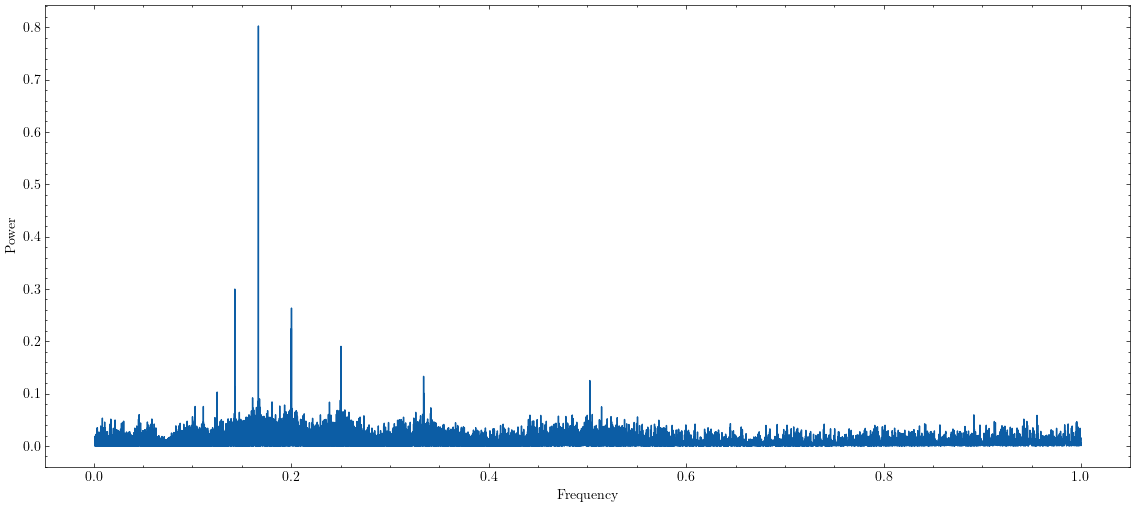

In [7]:
# import scienceplots
# plt.style.use("science")

b.run_solver('lcperiod_manual', solution='lcperiod_manual_solution', overwrite=True)
print(b['lcperiod_manual_solution'])

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(b.get_value('period@lcperiod_manual_solution'), b.get_value('power@lcperiod_manual_solution'))
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
plt.show()

0.33356641257553615 d 8.005593901812867 h


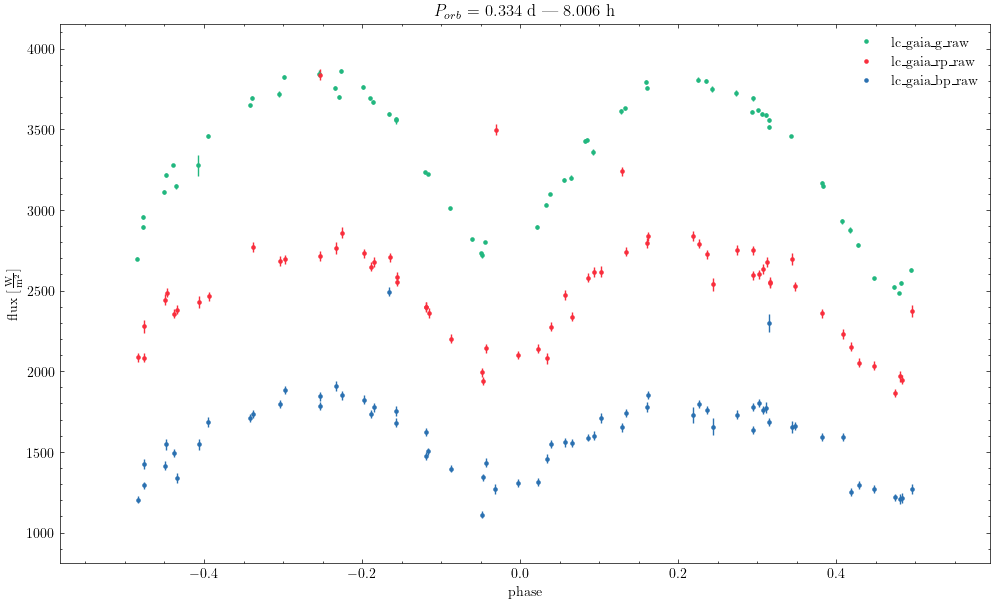

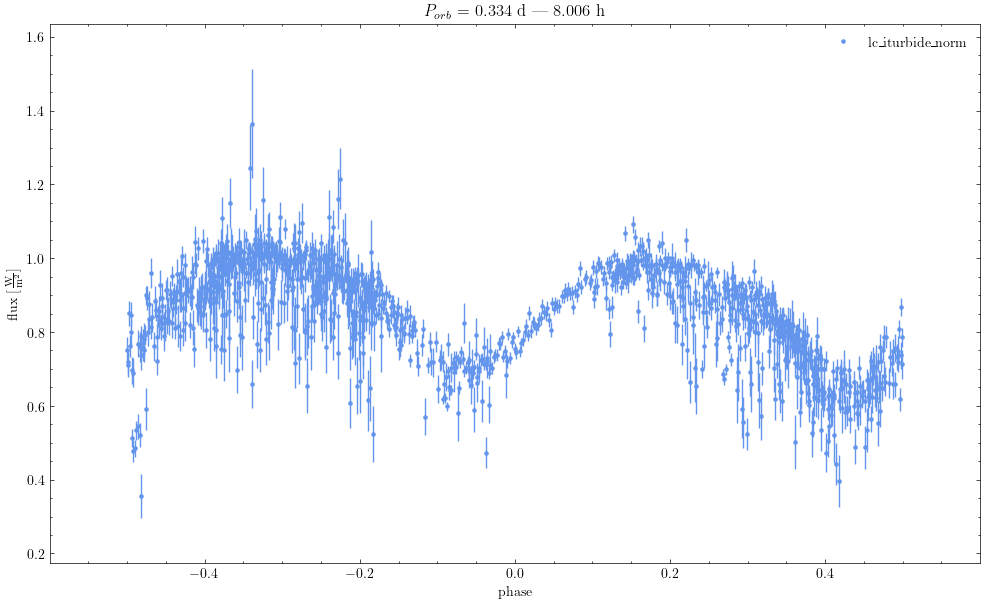

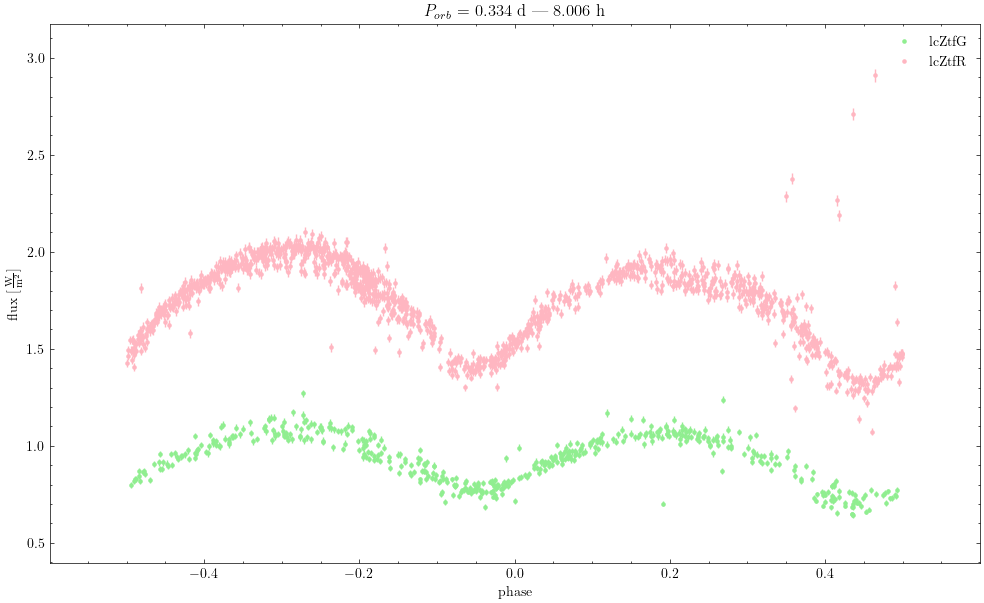

In [8]:
b.adopt_solution('lcperiod_manual_solution', period_factor=2)
period = b.get_quantity(qualifier='period', component='binary')
print(period, period.to(u.hour))

gen_utils.abilitateDatasets(b, ['lc_gaia_g_raw', 'lc_gaia_rp_raw', 'lc_gaia_bp_raw'])
gen_utils.phasePlotEnabledData(b, fig=plt.figure(figsize=(12, 7)))

gen_utils.abilitateDatasets(b, ['lc_iturbide_norm'])
gen_utils.phasePlotEnabledData(b, fig=plt.figure(figsize=(12, 7)))

gen_utils.abilitateDatasets(b, ['lcZtfG', 'lcZtfR'])
gen_utils.phasePlotEnabledData(b, fig=plt.figure(figsize=(12, 7)))

In [9]:
# gen_utils.saveBundle(b, "manual-periodogram")
# gen_utils.saveBundle(b, "manual-periodogram", "aviles-data")
# gen_utils.saveBundle(b, "manual-periodogram", "comp-LID3")
# gen_utils.saveBundle(b, bundleName="manual-periodogram", subfolder="clean-data")
gen_utils.saveBundle(b, bundleName="manual-periodogram", subfolder="detached")

Thu, 06 Jun 2024 01:55 PARAMETERS   WARNING for faster compact saving, install ujson


'bundle-saves/detached/manual-periodogram.json.gz'